# ProcessGrid

This notebook creates useful GIS shapefiles based on the 2D mesh that defines the SSM grid. In particular, it uses an input shapefile that defines a region of interest for analysis to create shapefiles that contain only the grid nodes within that region. Node IDs from the 2D mesh are preserved.

In [1]:
ssm_full_grid_file = "SSM_Grid/Salish_Sea_Shelf_top_0.2_DZ_10_3_16.2dm"

ssm_domain_shapefile = "gis/ssm domain utm.shp"

ssm_full_union_shp = "gis/ssm full union.shp"
domain_out_shp = "gis/ssm domain nodes.shp"
filled_domain_out_shp = "gis/ssm filled domain nodes.shp"

crs = "epsg:32610"

import py2dm
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

Read the 2DM file into several GeoDataFrames using Py2DM. This will result in separate GeoDataFrames for the nodes and elements, as well as a Pandas DataFrame that keeps track of the element-node relationships (similar to a junction table in SQL databases).

In [2]:
node_ids = []
node_points = []
node_depths = []
element_ids = []
element_centroids = []
element_node_el_ids = []
element_node_node_ids = []
# TODO this is all 2-dimensional at the moment, which means we can't easily compute the
# representative volume of a node at a given sigma layer. Once we have representative area
# for a given node working correctly, this code will be extended into 3 dimensions.
with py2dm.Reader(ssm_full_grid_file) as mesh:
    for node in mesh.iter_nodes():
        node_ids.append(node.id)
        node_points.append(Point(node.pos[:2]))
        node_depths.append(node.pos[2])
    for el in mesh.iter_elements():
        element_ids.append(el.id)
        element_centroids.append(Point(np.mean([mesh.node(i).pos[:2] for i in el.nodes], axis=0)))
        for node_id in el.nodes:
            element_node_el_ids.append(el.id)
            element_node_node_ids.append(node_id)

fullgrid = gpd.GeoDataFrame({
    "depth": node_depths,
    "geometry": node_points
}, index=node_ids, crs=crs)
elements = gpd.GeoDataFrame({
    "geometry": element_centroids
}, index=element_ids, crs=crs)
element_nodes = pd.DataFrame({
    "element_id": element_node_el_ids,
    "node_id": element_node_node_ids
})

fullgrid.head()

,depth,geometry
1,102.75730,POINT (413209.827 4916091.540)
2,128.44662,POINT (400581.392 4916573.430)
3,128.44662,POINT (390430.064 4916456.480)
4,131.31131,POINT (380630.000 4918330.000)
5,164.13914,POINT (375680.000 4925140.000)


These are the centroids of all the elements.

In [3]:
elements.head()

,geometry
1,POINT (410871.855 4921664.567)
2,POINT (406464.297 4918694.213)
3,POINT (400724.995 4922413.700)
4,POINT (395667.792 4920093.303)
5,POINT (390662.479 4923579.997)


This is the junction table that tracks which nodes are part of which elements.

In [4]:
element_nodes.head()

,element_id,node_id
0,1,88
1,1,1
2,1,89
3,2,88
4,2,2


Now that we have our DataFrames, use them to compute the shapes and representative areas around each node, as the polygon defined by the centroids of the surrounding elements.

Interior nodes are easy cases, where just the centroids of the surrounding elements and the midpoints to each neighbor node can be used to define a polygon. Exterior nodes, however, are not fully surrounded by elements and, in the SSM grid, can be part of exactly two elements which include an outer edge. The node itself is added in between both outer edge midpoints.

In [5]:
els_merged = elements.merge(element_nodes, left_index=True, right_on='element_id')
ns_merged = fullgrid.merge(element_nodes, left_index=True, right_on='node_id')
def azimuth(p1, p2):
    return np.arctan2(p2.y - p1.y, p2.x - p1.x)
def midpoint(p1, p2):
    return gpd.GeoSeries.from_xy((p1.x + p2.x) / 2, (p1.y + p2.y) / 2)

node_shapes = []
for node_id,row in fullgrid.iterrows():
    node_pt = row['geometry']

    # Start by gathering the centroids of all the elements
    els = els_merged.loc[els_merged['node_id'] == node_id]
    points = els.copy()['geometry']
    #print("Elements:")
    #print(els)

    # Get the list of nodes that are part of those elements (the neighbors)
    neighbor_nodes = ns_merged.loc[ns_merged['element_id'].isin(els['element_id']) & (ns_merged['node_id'] != node_id)]
    #print("Neighbors:")
    #print(neighbor_nodes)

    # Add all the midpoints between this node and its neighbors.
    # If there are any neighbor nodes that are only part of one element, then this is an
    # exterior node and the segment between this node and that neighbor constitutes an edge
    nei_counts = neighbor_nodes.groupby('node_id').count()['geometry']
    nei_counts = neighbor_nodes.copy()
    nei_counts['dupl'] = nei_counts.duplicated(subset=('node_id'), keep='last')
    nei_counts.drop_duplicates(subset=('node_id'), inplace=True)
    #print(nei_counts)
    midpoints = midpoint(node_pt, nei_counts['geometry'])
    points = pd.concat((points, midpoints))
    edge_mids = midpoints.loc[~nei_counts['dupl']]

    # Order the element centroids around the node with a sort by angle
    points = points.to_list()
    points.sort(key=lambda x: azimuth(node_pt, x))
    # If there are midpoints added (exterior node), add the node point itself to the
    # list in between the two
    if len(edge_mids):
        # There are guaranteed to be exactly two midpoints if the grid is structured properly
        assert len(edge_mids) == 2, "Node {0} has {1} neighboring edges???".format(node_id, len(mids))
        m1 = edge_mids.iloc[0]
        m2 = edge_mids.iloc[1]
        i1 = points.index(m1)
        i2 = points.index(m2)
        # If they are consecutive, insert between
        if abs(i1 - i2) == 1:
            points.insert(max(i1, i2), node_pt)
        else:
            # The only other possibility is that one is at the end of the list and the other
            # at the beginning, so just append the node_pt to the end
            points.append(node_pt)
    #print("Sorted list of points:")
    #print(gpd.GeoSeries(points))

    shape = Polygon([(el.x, el.y) for el in points])
    #display(shape)
    node_shapes.append(shape)

filled_grid = gpd.GeoDataFrame({
    "geometry": node_shapes
}, index=node_ids, crs=crs)
filled_grid.head()

,geometry
1,"POLYGON ((413506.946 4920788.015, 410871.855 4..."
2,"POLYGON ((395505.728 4916514.955, 400581.392 4..."
3,"POLYGON ((395505.728 4916514.955, 395667.792 4..."
4,"POLYGON ((385530.032 4917393.240, 385541.839 4..."
5,"POLYGON ((378155.000 4921735.000, 380625.151 4..."


Load the shapefile that defines the domain of interest for results analysis. This file contains one or more region boundaries that contain the relevant portion of the model grid, created by hand in GIS software.

In [6]:
domain = gpd.read_file(ssm_domain_shapefile)
domain.head()

,FID,geometry
0,0,"POLYGON ((515248.761 5331015.833, 515248.761 5..."


Plot the grid overlaid on the domain of interest

<AxesSubplot:>

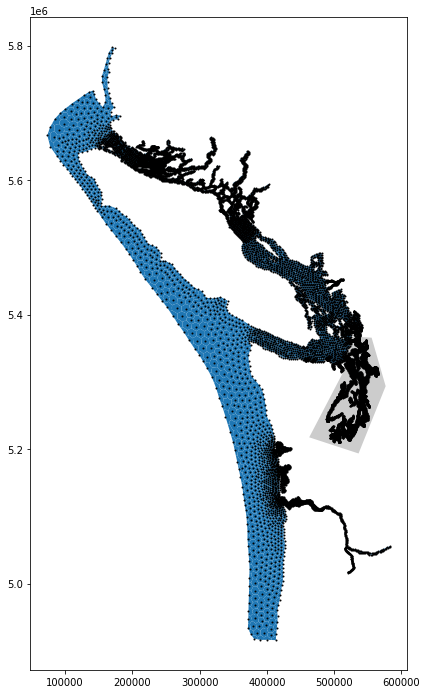

In [7]:
fig, ax = plt.subplots(figsize=(8,12))
filled_grid.plot(ax=ax)
domain.plot(ax=ax, color='gray', alpha=0.4)
fullgrid.plot(ax=ax, color='black', markersize=1)

Make a union of all the nodes so we have a single polygon to use for plotting a background geography.

<AxesSubplot:>

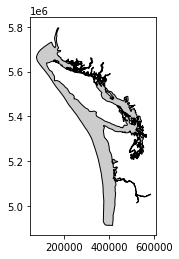

In [8]:
full_union = gpd.GeoDataFrame({'geometry': gpd.GeoSeries(unary_union(filled_grid['geometry']))})
full_union.plot(facecolor='#ccc', edgecolor='k')

In [9]:
full_union.to_file(ssm_full_union_shp)

With the domain and the nodes defined, we can perform the spatial join to find just the nodes within the domain.

In [10]:
domain_nodes = gpd.tools.sjoin(fullgrid, domain)
domain_nodes.head()

,depth,geometry,index_right,FID
4369,45.183998,POINT (515771.670 5333564.600),0,0
4370,51.813999,POINT (515865.500 5334886.900),0,0
4371,51.813999,POINT (516496.440 5336059.500),0,0
4372,55.544998,POINT (517099.320 5337226.800),0,0
4373,60.431000,POINT (518039.180 5338339.500),0,0


A bit of cleanup is required on this resulting GeoDataFrame, then save it.

In [11]:
del domain_nodes['index_right'], domain_nodes['FID']
domain_nodes.index.name = "node_id"
domain_nodes.to_file(domain_out_shp)

Create another version for the filled node areas.

In [12]:
filled_domain_nodes = filled_grid.loc[domain_nodes.index]
filled_domain_nodes['depth'] = domain_nodes['depth']
filled_domain_nodes.head()

,geometry,depth
node_id,,
4369,"POLYGON ((515282.150 5333310.800, 515468.573 5...",45.183998
4370,"POLYGON ((515087.250 5334738.350, 515315.390 5...",51.813999
4371,"POLYGON ((515720.085 5336024.300, 515768.557 5...",51.813999
4372,"POLYGON ((516396.973 5336859.567, 516797.880 5...",55.544998
4373,"POLYGON ((517118.153 5338021.300, 517569.250 5...",60.431000


In [13]:
filled_domain_nodes.to_file(filled_domain_out_shp)